# Convection Diffusion Fractional PDE

This notebook contains a Julia implementation of the meethod described in the following conference paper:

Jacky Cresson, Fernando Jiménezk, Sina Ober-Blöbaum<br>
<i>Modelling of the Convection-Diffusion Equation through Fractional Restricted Calculus of Variations</i><br>
IFAC-PapersOnLine, Volume 54, Issue 9, 2021, Pages 482-487<br>
https://doi.org/10.1016/j.ifacol.2021.06.105


In [1]:
# load packages
using FFTW
using ToeplitzMatrices
using LinearAlgebra
using Plots
using NLsolve
using ProgressMeter

In [2]:
# Constants and forcing term
K = -.15        # diffusion
gamma = .4     # advection
xi = 0.0        # reaction
alpha = .5     # fractional
beta = .5     # fractional
force(u) = 0.   # external forces

# discretisation parameters
dt = 0.1# time step size
dx = 0.1 # spacial step size
N = 40 # number of time steps (not including initial condition)
M = 100; # number of inner spacial gridpoints 

tt = dt*(0:N)   # time grid
xx = dx*(0:M+1); # space grid with boundary
(-K)/gamma-dx       # mesh Peclet condition (>=0)

0.2749999999999999

In [3]:
# fractional factorial

function An(alpha,n)
    A=zeros(n+1)
    A[1] = 1
    for j=1:n
        A[j+1] = (j-1 - alpha)*A[j]/j
    end
    return A
end
    

An (generic function with 1 method)

In [4]:
# discretisation matrix for central differences d_{xx} for Dirichlet boundary conditions

T2=Circulant([-2.;1;zeros(Int,M-3);1]) # discerete central differences d_{xx}
T2 = T2*Matrix{Float64}(I, M, M)       # convert to matrix

# Dirichlet conditions
T2[1,end]=0
T2[end,1]=0
T2 = [[1;zeros(M-1,1)] T2 [zeros(M-1,1);1]];

In [5]:
# discretisation matrix for fractional spacial derivative for homogeneous Dirichlet boundary conditions

T1=Circulant(An(alpha+beta,M+2))         
T1 = T1*Matrix{Float64}(I, M+2, M+2)       # convert to matrix
T1 = tril(T1)[1:end-1,:]
T1 = T1[2:end-1,:];

In [6]:
# spacial discretisation
rhs(U) = force.(U[2:end-1]) - xi.*U[2:end-1] - K/dx^2 * T2*U - gamma/(dx^(alpha+beta)) * T1*U

rhs (generic function with 1 method)

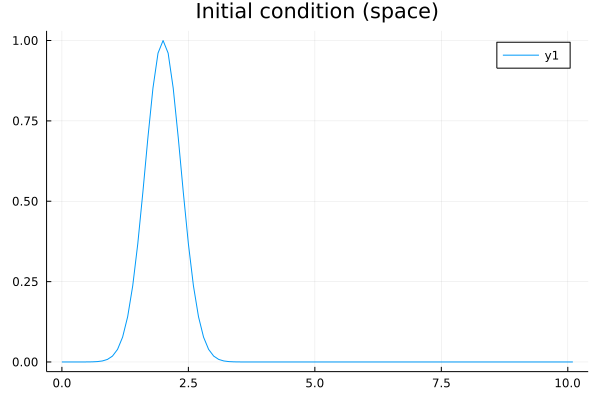

In [7]:
# Dirichlet boundary condition
uleft = zeros(N+1,1)
uright = range(0,stop=0.1,length=N+1)

# initial condition
u0 = exp.(-4.0*(xx.-2.0).^2)
plot(xx,u0,title="Initial condition (space)")

In [8]:
# initialisation of scheme
U = Array{Float64, 2}(undef, N+1, M+2) # pre-allocating memory
U[1,:] = u0;                # set initial condition
U[:,1] = uleft;             #  set left boundary
U[:,end] = uright;          #  set right boundary

In [9]:
# run the fractional scheme over time

@showprogress for j = 2:N+1
    
    function objective(UjInner)
        Uj = [uleft[j];UjInner;uright[j]]
        UUpToNow = [U[1:j-1,:];transpose(Uj)]
        return 1/dt^(alpha+beta)*transpose(transpose(reverse(An(alpha+beta,j-1)))*UUpToNow)[2:end-1] - rhs(Uj)
    end
        
    U[j,2:end-1] = nlsolve(objective,U[j-1,2:end-1]).zero
end

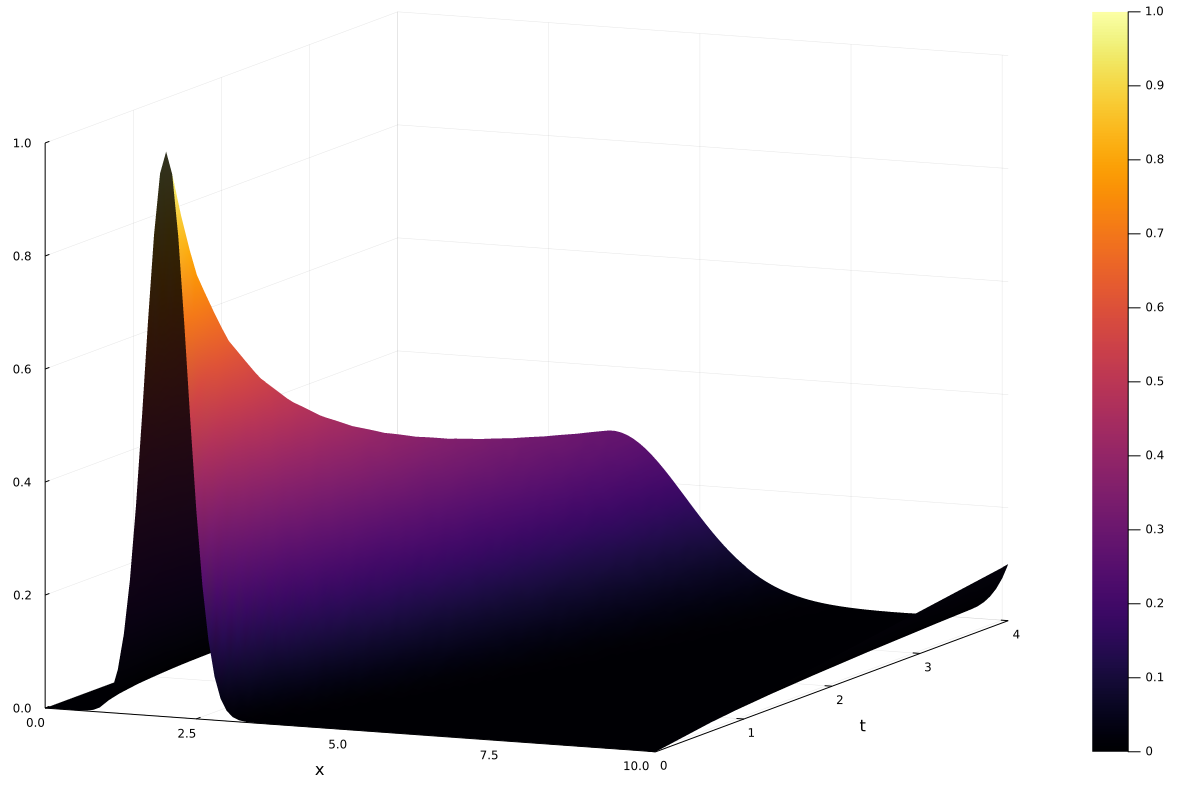

In [20]:
# plot result
plot(xx,tt,U,st=:surface,xlabel="x",ylabel="t",size=(1200,800))
#savefig("PDE_plot_result.png")